# Proyecto XAI 
## Clasificación de Imágenes Reales vs Generadas por IA

Este notebook implementa un clasificador de redes neuronales convolucionales para distinguir entre imágenes reales y generadas por IA.

In [ ]:
os.environ['KAGGLE_USERNAME'] = os.getenv('KAGGLE_USERNAME')
os.environ['KAGGLE_KEY'] = os.getenv('KAGGLE_KEY')
!kaggle datasets download birdy654/cifake-real-and-ai-generated-synthetic-images
!unzip cifake-real-and-ai-generated-synthetic-images.zip

## 1. Importar bibliotecas necesarias

In [131]:
import os
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers, models, metrics
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import load_img, img_to_array, array_to_img
from PIL import Image
import tqdm as tqdm
from sklearn.utils import shuffle

# Lime|
from lime import lime_image 
from skimage.segmentation import mark_boundaries

# Comprobar si estamos usando GPU
print(tf.config.list_physical_devices('GPU'))
!nvidia-smi

# Configurar el nivel de registro para reducir mensajes de TensorFlow
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3' 

# Configurar semilla aleatoria para reproducibilidad
tf.random.set_seed(42)
np.random.seed(42)

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
Tue May 27 00:09:16 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 565.72                 Driver Version: 566.14         CUDA Version: 12.7     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
Tue May 27 00:09:16 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 565.72                 Driver Version: 566.14         CUDA Version: 12.7     |
|----------------------------------------

## 2. Definir función para cargar el conjunto de datos

In [118]:
FILE_PATH = '../'
IMG_SIZE = 224
BATCH_SIZE = 64

def get_labels(path):
    all_image_paths = []
    all_labels = []
    class_names = ['FAKE', 'REAL']

    for class_idx, class_name in enumerate(class_names):
        class_dir = os.path.join(path, class_name)
        if os.path.exists(class_dir):
            image_files = [f for f in os.listdir(class_dir) 
                        if f.lower().endswith(('.png', '.jpg', '.jpeg'))]
            
            for img_file in image_files:
                img_path = os.path.join(class_dir, img_file)
                all_image_paths.append(img_path)
                all_labels.append(class_idx)

    # Convertir a arrays numpy
    all_image_paths = np.array(all_image_paths)
    all_labels = np.array(all_labels)
    return all_image_paths, all_labels

# Define función para cargar y preprocesar imágenes
def load_and_preprocess(path, label):
    img = tf.io.read_file(path)
    img = tf.image.decode_image(img, channels=3, expand_animations=False)
    img = tf.image.convert_image_dtype(img, tf.float32)  # Normaliza a [0,1]
    img = tf.image.resize(img, [IMG_SIZE, IMG_SIZE])
    label = tf.cast(label, tf.float32)
    return img, tf.reshape(label, (1,))


def load_dataset(paths, labels, batch_size, shuffle_data=True):
    """
    Crea un generador de datos que carga imágenes por lotes para ahorrar memoria.
    """    
    
    # Mezclar datos si es necesario
    if shuffle_data:
        indices = np.arange(len(paths))
        np.random.seed(42)
        np.random.shuffle(indices)
        paths = paths[indices]
        labels = labels[indices]
    
    dataset = tf.data.Dataset.from_tensor_slices((paths, labels))
    
    # Apply preprocessing, batching and prefetching
    dataset = dataset.map(load_and_preprocess, num_parallel_calls=tf.data.AUTOTUNE)
    dataset = dataset.batch(batch_size)
    dataset = dataset.prefetch(tf.data.AUTOTUNE)
    
    return dataset

## 3. Cargar y preparar los datos

In [119]:
# Establecer rutas a las carpetas de datos
train_dir = 'train'  


# Crear sets de entrenamiento y validación
data_dir = os.path.join(FILE_PATH, train_dir)

# Obtener rutas de imágenes y etiquetas
all_image_paths, all_labels = get_labels(data_dir)

# Dividir en conjuntos de entrenamiento y validación
train_paths, val_paths, train_labels, val_labels = train_test_split(
    all_image_paths, all_labels, test_size=0.2, random_state=42
)

# Crear datasets
train_ds = load_dataset(train_paths, train_labels, BATCH_SIZE)
val_ds = load_dataset(val_paths, val_labels, BATCH_SIZE)

print(f"Conjunto de entrenamiento: {len(train_paths)} imágenes")
print(f"Conjunto de validación: {len(val_paths)} imágenes")

Conjunto de entrenamiento: 80000 imágenes
Conjunto de validación: 20000 imágenes


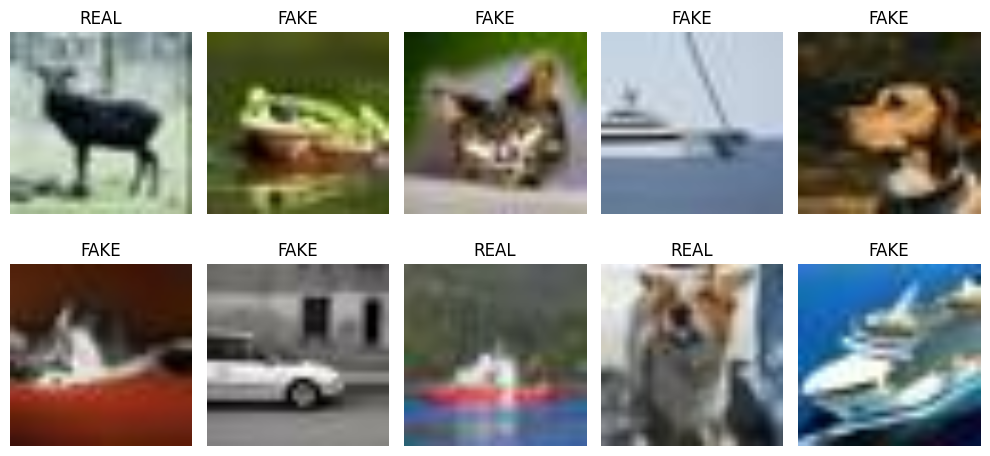

In [120]:
# Visualizar algunas imágenes de ejemplo
sample_size = 10
sample_images, sample_labels = [], []
for images, labels in train_ds.take(1):  # Tomar solo un lote
    for i in range(min(sample_size, len(images))):
        sample_images.append(images[i].numpy())
        sample_labels.append(labels[i].numpy())

# Visualizar imágenes de muestra
plt.figure(figsize=(10, 5))
for i in range(len(sample_images)):
    plt.subplot(2, 5, i+1)
    plt.imshow(sample_images[i])
    class_name = ['FAKE', 'REAL'][int(sample_labels[i][0])]
    plt.title(class_name)
    plt.axis('off')
plt.tight_layout()
plt.show()

## 5. Definir arquitectura del modelo

### Modelo Propio


In [121]:
# Definir el modelo
input_shape = (IMG_SIZE, IMG_SIZE, 3)

data_augmentation = tf.keras.Sequential([
    layers.RandomFlip("horizontal"),
    layers.RandomRotation(0.1),
    layers.RandomZoom(0.1),
])

model = models.Sequential([
    layers.Input(input_shape),
    data_augmentation,
    layers.Conv2D(64, kernel_size=3, padding='same', activation='relu'),
    layers.BatchNormalization(),
    layers.MaxPool2D(4),
    layers.Dropout(0.1),
    layers.Conv2D(128, kernel_size=3, padding='same', activation='relu', name='last_conv_layer'),
    layers.BatchNormalization(),
    layers.MaxPool2D(4),
    layers.Dropout(0.1),
    layers.Flatten(),
    layers.Dense(64, activation='relu', name='output_layer'),
    layers.Dense(1, activation='sigmoid')
])

# Compilar el modelo
model.compile(
    optimizer='adam', 
    loss='binary_crossentropy', 
    metrics=['accuracy', metrics.F1Score(threshold=0.5)]
)

# Imprimir resumen del modelo
model.summary()

Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ sequential_3 (Sequential)       │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 224, 224, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 224, 224, 64)   │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 56, 56, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 56, 56, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ last_conv_layer (Conv2D)        │ (None, 56, 56, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 56, 56, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 14, 14, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 14, 14, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_4 (Flatten)             │ (None, 25088)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ output_layer (Dense)            │ (None, 64)             │     1,605,696 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,682,177 (6.42 MB)

 Trainable params: 1,681,793 (6.42 MB)

 Non-trainable params: 384 (1.50 KB)

In [ ]:
# Aumentación de datos para entrenamiento
data_augmentation = tf.keras.Sequential([
    layers.RandomFlip("horizontal"),
    layers.RandomRotation(0.1),
    layers.RandomZoom(0.1),
])

# Callback de early stopping
es_callback = tf.keras.callbacks.EarlyStopping(
    patience=10,
    verbose=1,
    restore_best_weights=True
)


# Checkpoint del modelo para guardar el mejor modelo
checkpoint = tf.keras.callbacks.ModelCheckpoint(
    'CIFAKE.keras',
    monitor='val_accuracy',
    save_best_only=True,
    verbose=1
)

In [ ]:
# Entrenar el modelo
history = model.fit(
    train_ds,
    batch_size=BATCH_SIZE,
    epochs=100,
    callbacks=[es_callback, checkpoint],
    validation_data=val_ds,
    verbose=1
)

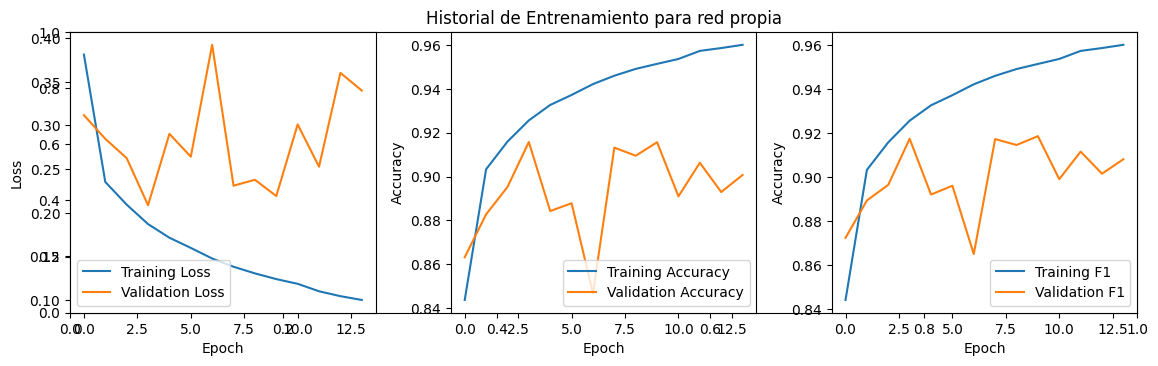

In [13]:
# Graficar historial de entrenamiento
plt.figure(figsize=(12, 4))
plt.title('Historial de Entrenamiento para red propia')

# Loss
plt.subplot(1, 3, 1)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

# Accuracy
plt.subplot(1, 3, 2)
plt.plot(history.history['accuracy'], label='Training Accuracy')   
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

# F1
plt.subplot(1, 3, 3)
plt.plot(history.history['f1_score'], label='Training F1')
plt.plot(history.history['val_f1_score'], label='Validation F1')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.savefig('historial_entrenamiento.png')
plt.show()

### VGG16

In [122]:
# Utilizar transfer learning con VGG16
from tensorflow.keras.applications import VGG16

# Aumentación de datos
data_augmentation = tf.keras.Sequential([
    layers.RandomFlip("horizontal"),
    layers.RandomRotation(0.1),
    layers.RandomZoom(0.1),
])
inputs = layers.Input(shape=(IMG_SIZE, IMG_SIZE, 3))
x = data_augmentation(inputs)

base_model = VGG16(weights='imagenet', include_top=False, input_shape=(IMG_SIZE, IMG_SIZE, 3))

# Congelar las capas de la base para evitar que se entrenen
for layer in base_model.layers:
    layer.trainable = False

x = base_model(x, training=False)
x = layers.Flatten()(x)
x = layers.Dense(256, activation='relu')(x)
x = layers.Dropout(0.2)(x)
predictions = layers.Dense(1, activation='sigmoid')(x)

model = models.Model(inputs=inputs, outputs=predictions)

# Compilar el modelo
model.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics=['accuracy', metrics.F1Score(threshold=0.5)]
)

# Imprimir resumen del modelo
model.summary()

Model: "functional_27"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_10 (InputLayer)     │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ sequential_5 (Sequential)       │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ vgg16 (Functional)              │ (None, 7, 7, 512)      │    14,714,688 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_5 (Flatten)             │ (None, 25088)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ (None, 256)            │     6,422,784 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_6 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_10 (Dense)                │ (None, 1)              │           257 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 21,137,729 (80.63 MB)

 Trainable params: 6,423,041 (24.50 MB)

 Non-trainable params: 14,714,688 (56.13 MB)

In [123]:
# Callback de early stopping
es_callback = tf.keras.callbacks.EarlyStopping(
    patience=5,
    verbose=1,
    restore_best_weights=True
)

# Checkpoint del modelo para guardar el mejor modelo
checkpoint = tf.keras.callbacks.ModelCheckpoint(
    #'CIFAKE.keras',
    'VGG_CIFAKE.keras',
    monitor='val_accuracy',
    save_best_only=True,
    verbose=1
)

In [ ]:
# Entrenar el modelo
history = model.fit(
    train_ds,
    batch_size=BATCH_SIZE,
    epochs=30,
    callbacks=[es_callback, checkpoint],
    validation_data=val_ds,
    verbose=1
)

In [ ]:
# Fine Tuning

# Descongelamos el ultimo bloque de capas convolucionales
for layer in base_model.layers[-4:]:
    layer.trainable = True

for layer in model.layers:
  if layer.trainable:
    print(f"{layer.name}: Trainable = {layer.trainable}")

# Compilamos el modelo con un learning rate bajo para evitar grandes cambios en los pesos
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-5),
    loss='binary_crossentropy',
    metrics=['accuracy', metrics.F1Score(threshold=0.5)]
)

history_unfrozen = model.fit(
    train_ds,
    batch_size=BATCH_SIZE,
    epochs=30,
    callbacks=[es_callback, checkpoint],
    validation_data=val_ds,
    verbose=1
)

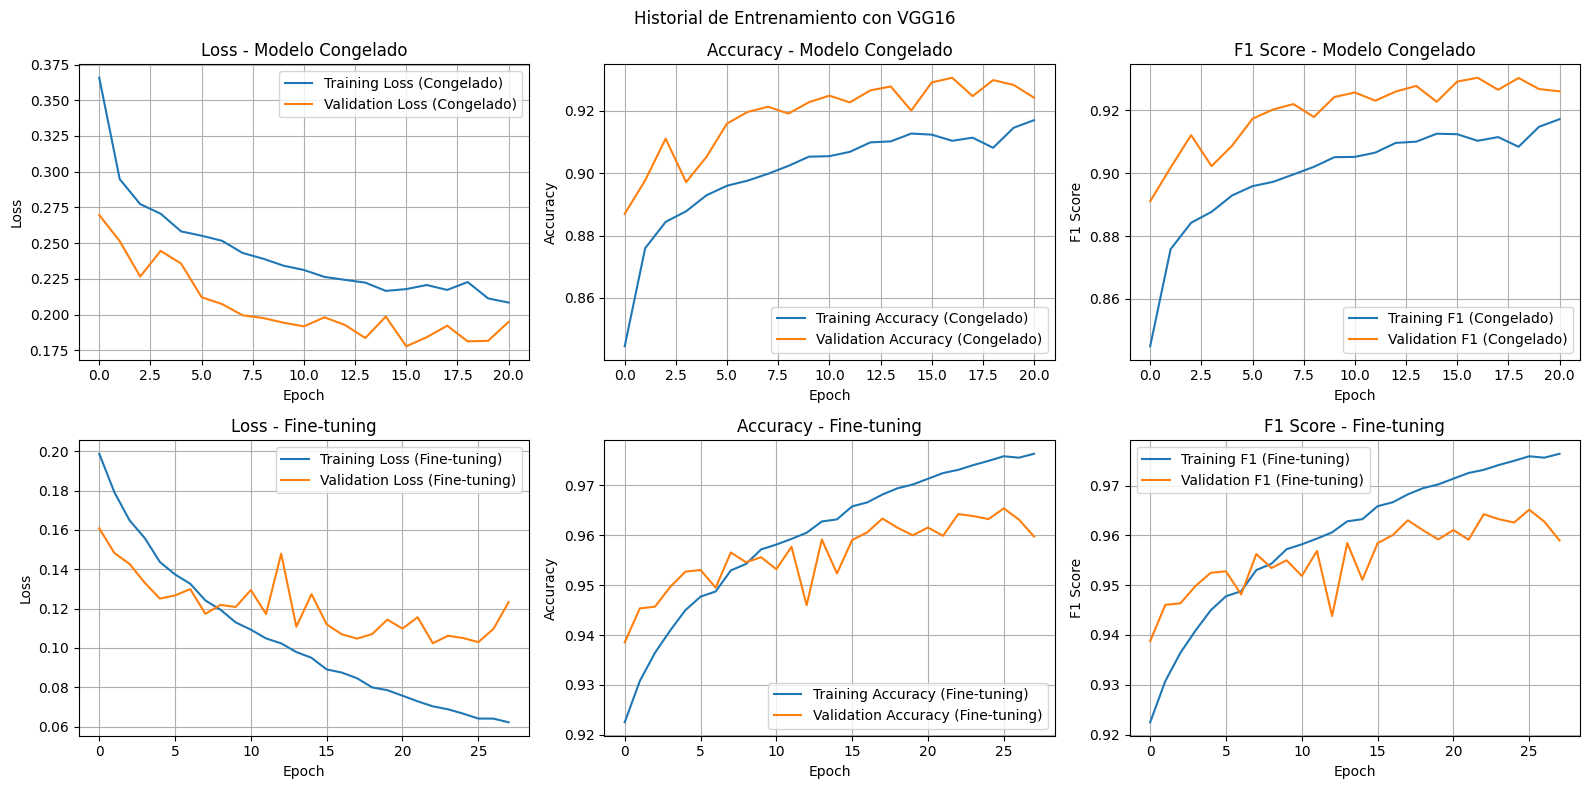

In [129]:
# Graficar historial de entrenamiento
plt.figure(figsize=(16, 8))
plt.suptitle('Historial de Entrenamiento con VGG16')

# Primera fila: Entrenamiento con VGG16 Congelado
# Loss 
plt.subplot(2, 3, 1) 
plt.plot(history.history['loss'], label='Training Loss (Congelado)')
plt.plot(history.history['val_loss'], label='Validation Loss (Congelado)')
plt.title('Loss - Modelo Congelado')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

# Accuracy
plt.subplot(2, 3, 2) 
plt.plot(history.history['accuracy'], label='Training Accuracy (Congelado)')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy (Congelado)')
plt.title('Accuracy - Modelo Congelado')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)

# F1 Score 
plt.subplot(2, 3, 3) 
plt.plot(history.history['f1_score'], label='Training F1 (Congelado)')
plt.plot(history.history['val_f1_score'], label='Validation F1 (Congelado)')
plt.title('F1 Score - Modelo Congelado')
plt.xlabel('Epoch')
plt.ylabel('F1 Score') 
plt.legend()
plt.grid(True)

# Segunda fila: Entrenamiento con VGG16 Descongelado

# Loss 
plt.subplot(2, 3, 4) 
plt.plot(history_unfrozen.history['loss'], label='Training Loss (Fine-tuning)')
plt.plot(history_unfrozen.history['val_loss'], label='Validation Loss (Fine-tuning)')
plt.title('Loss - Fine-tuning')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

# Accuracy 
plt.subplot(2, 3, 5) 
plt.plot(history_unfrozen.history['accuracy'], label='Training Accuracy (Fine-tuning)')
plt.plot(history_unfrozen.history['val_accuracy'], label='Validation Accuracy (Fine-tuning)')
plt.title('Accuracy - Fine-tuning')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)

# F1 Score 
plt.subplot(2, 3, 6) 
plt.plot(history_unfrozen.history['f1_score'], label='Training F1 (Fine-tuning)')
plt.plot(history_unfrozen.history['val_f1_score'], label='Validation F1 (Fine-tuning)')
plt.title('F1 Score - Fine-tuning')
plt.xlabel('Epoch')
plt.ylabel('F1 Score') 
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.savefig('historial_entrenamiento_vgg16_combinado.png')
plt.show()

## 9. Hacer predicciones en el conjunto de prueba

In [130]:
# Evaluar el modelo en el conjunto de prueba
# Crear el conjunto de prueba
test_dir = 'test'  

# Crear sets de entrenamiento y validación
data_dir = os.path.join(FILE_PATH, test_dir)

# Obtener rutas de imágenes y etiquetas
all_image_paths , all_labels = get_labels(data_dir) 

test_ds = load_dataset(all_image_paths, all_labels, BATCH_SIZE)

# Evaluate with dataset
test_results = model.evaluate(test_ds, verbose=1)

313/313 ━━━━━━━━━━━━━━━━━━━━ 44s 142ms/step - accuracy: 0.9622 - f1_score: 0.9622 - loss: 0.1101
313/313 ━━━━━━━━━━━━━━━━━━━━ 44s 142ms/step - accuracy: 0.9622 - f1_score: 0.9622 - loss: 0.1101


## 10. Visualizar predicciones

1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step


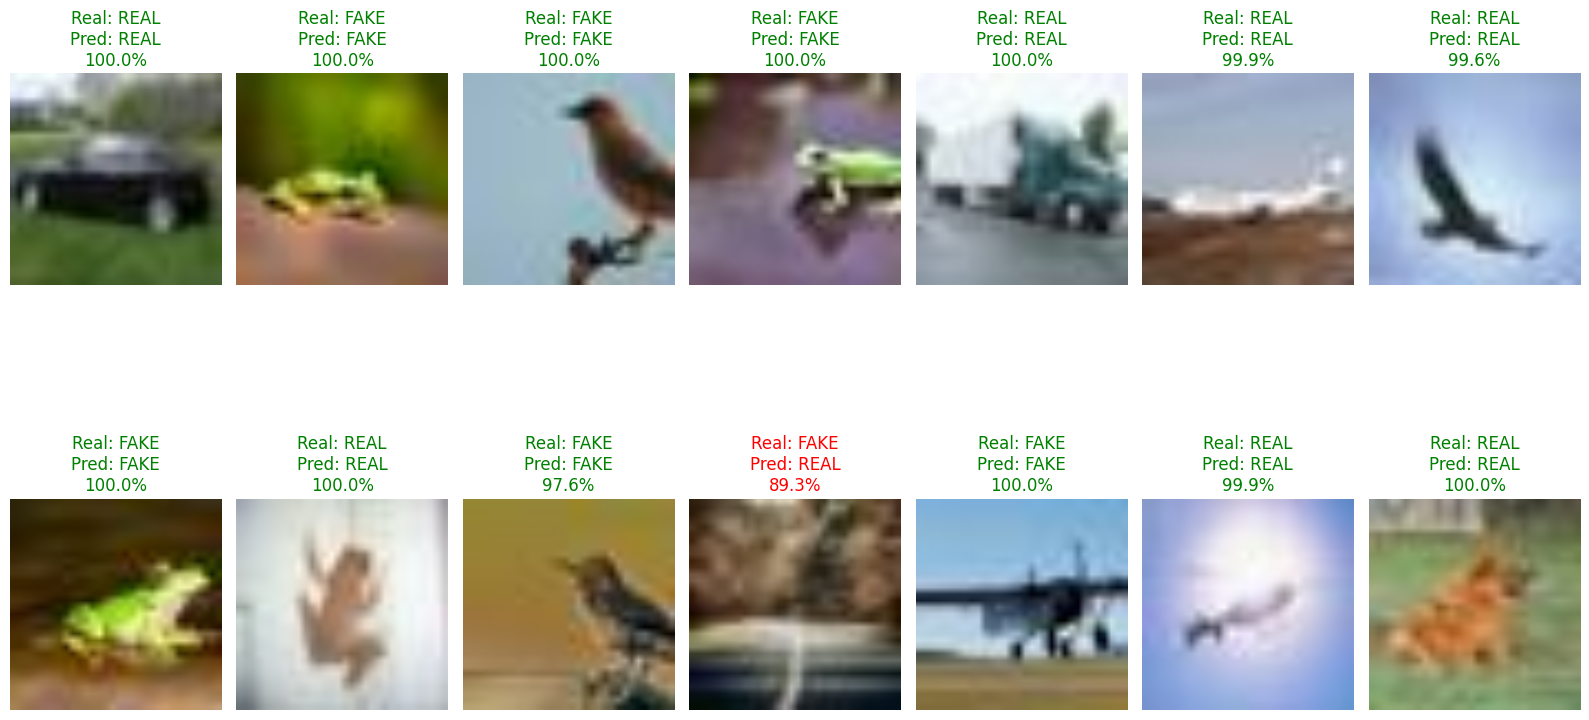

Métricas en la muestra visualizada:
Accuracy: 0.9286
Precision score: 0.8750
Recall score: 1.0000
F1 score: 0.9333

Matriz de confusión:
[[6 1]
 [0 7]]


In [16]:
# Obtener imágenes y etiquetas de test_ds
sample_size = 14  # Número de imágenes a visualizar
images_to_show = []
labels_to_show = []
count = 0

# Recopilar algunas imágenes del dataset de prueba
for images, labels in test_ds.take(3):  # Tomar 3 batches para tener suficientes imágenes
    for i in range(len(images)):
        if count >= sample_size:
            break
        images_to_show.append(images[i].numpy())
        labels_to_show.append(labels[i].numpy()[0])
        count += 1
    if count >= sample_size:
        break

# Realizar predicciones
predictions = model.predict(np.array(images_to_show))
predictions = predictions.flatten()
pred_classes = (predictions > 0.5).astype(int)

# Visualizar imágenes con sus predicciones
plt.figure(figsize=(16, 10))
for i in range(len(images_to_show)):
    plt.subplot(2, 7, i+1)
    plt.imshow(images_to_show[i])
    
    true_class = ['FAKE', 'REAL'][int(labels_to_show[i])]
    pred_class = ['FAKE', 'REAL'][pred_classes[i]]
    confidence = predictions[i] * 100 if pred_classes[i] == 1 else (1 - predictions[i]) * 100
    
    color = 'green' if true_class == pred_class else 'red'
    plt.title(f"Real: {true_class}\nPred: {pred_class}\n{confidence:.1f}%", color=color)
    plt.axis('off')
plt.tight_layout()
plt.show()

# Calcular métricas de rendimiento
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix

accuracy = accuracy_score(labels_to_show, pred_classes)
precision = precision_score(labels_to_show, pred_classes, average='binary')
recall = recall_score(labels_to_show, pred_classes, average='binary')
f1 = f1_score(labels_to_show, pred_classes, average='binary')
conf_matrix = confusion_matrix(labels_to_show, pred_classes)

print(f"Métricas en la muestra visualizada:")
print(f"Accuracy: {accuracy:.4f}")
print(f"Precision score: {precision:.4f}")
print(f"Recall score: {recall:.4f}")
print(f"F1 score: {f1:.4f}")
print("\nMatriz de confusión:")
print(conf_matrix)

# Explicabilidad del Modelo

In [73]:
# Cargamos imagenes de prueba
images = images_to_show
"""
img_paths = ['../test/REAL/0000.jpg',"/mnt/d/test/000a8769fc78487a9163852d7a2a048d.jpg", "/mnt/d/test/000aaacc53f94d708736b845704dcaaa.jpg", "/mnt/d/test/000c4ee98dfa437195b2b6881da89dcf.jpg", "/mnt/d/test/000c403fd07740e3aef76244ff31743e.jpg", "/mnt/d/test/000fe90b4fb14fca9d250167e77e3d10.jpg", "/mnt/d/test/000ff55056384d61972bda1b6bd80701.jpg"]

# Preprocesar imágenes y almacenarlas en un array
images = np.zeros((len(img_paths), IMG_SIZE, IMG_SIZE, 3))
for i, img_path in enumerate(img_paths):
    img = Image.open(img_path).resize((IMG_SIZE, IMG_SIZE))
    img = img.convert('RGB') 
    img_array = img_to_array(img)
    img_array = img_array / 255.0
    images[i] = img_array
"""

'\nimg_paths = [\'../test/REAL/0000.jpg\',"/mnt/d/test/000a8769fc78487a9163852d7a2a048d.jpg", "/mnt/d/test/000aaacc53f94d708736b845704dcaaa.jpg", "/mnt/d/test/000c4ee98dfa437195b2b6881da89dcf.jpg", "/mnt/d/test/000c403fd07740e3aef76244ff31743e.jpg", "/mnt/d/test/000fe90b4fb14fca9d250167e77e3d10.jpg", "/mnt/d/test/000ff55056384d61972bda1b6bd80701.jpg"]\n\n# Preprocesar imágenes y almacenarlas en un array\nimages = np.zeros((len(img_paths), IMG_SIZE, IMG_SIZE, 3))\nfor i, img_path in enumerate(img_paths):\n    img = Image.open(img_path).resize((IMG_SIZE, IMG_SIZE))\n    img = img.convert(\'RGB\') \n    img_array = img_to_array(img)\n    img_array = img_array / 255.0\n    images[i] = img_array\n'

## LIME

Modelo cargado correctamente
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 540ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


/tmp/ipykernel_1032/4261361095.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  prediction = float(prediction)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


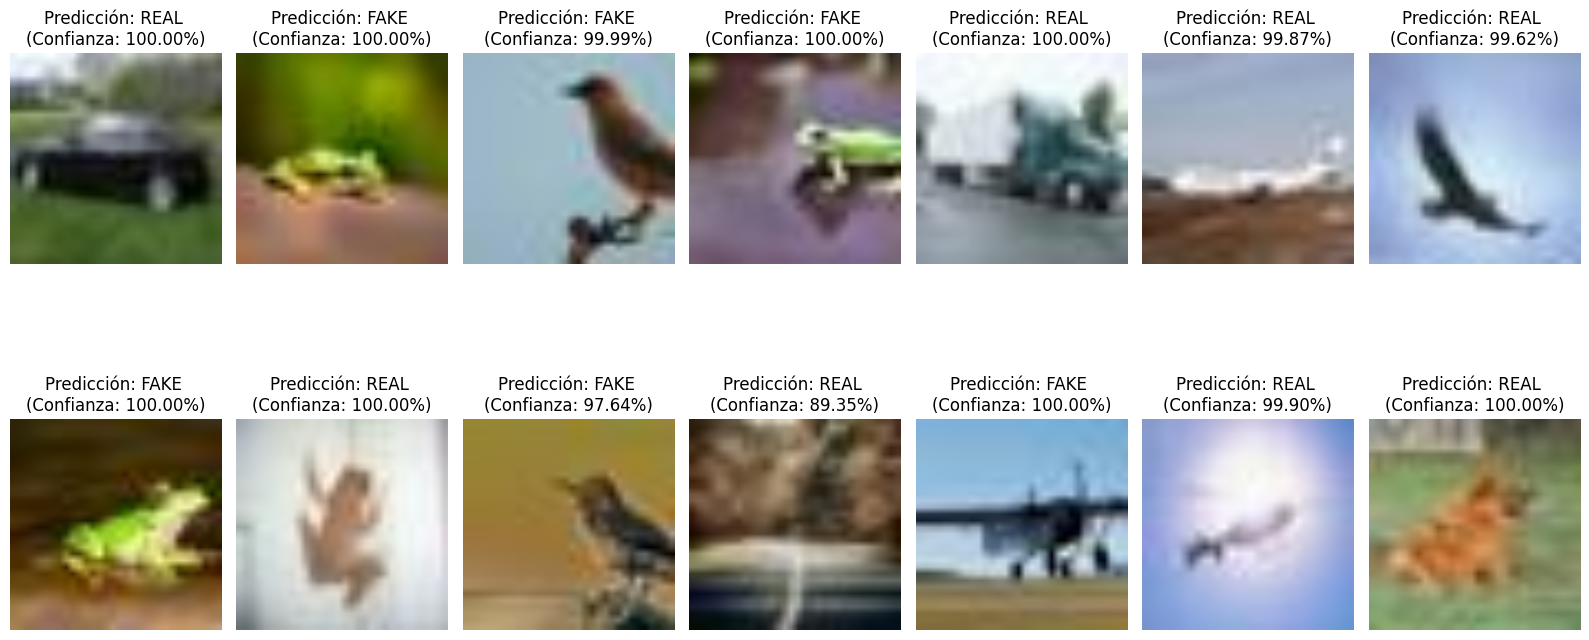

In [74]:
# Ejemplo de cómo cargar el modelo guardado para inferencia

model = tf.keras.models.load_model('VGG_CIFAKE.keras')
#model = tf.keras.models.load_model('CIFAKE.keras')
print("Modelo cargado correctamente")

# Probar con una sola imagen
def predict_single_image(img_array, model):     
    # Agregar dimensión de batch si es necesario
    if len(img_array.shape) == 3:
        img_array = np.expand_dims(img_array, axis=0)
    
    # Predecir
    prediction = model.predict(img_array)[0]
    # print(f"Valor de predicción: {prediction}")
    prediction = float(prediction)
    predicted_class = 1 if prediction >= 0.5 else 0
    confidence = prediction * 100 if predicted_class == 1 else (1 - prediction) * 100
    
    return ['FAKE', 'REAL'][predicted_class], confidence


# Realizar predicción
plt.figure(figsize=(16, 8))
for i, image in enumerate(images_to_show):
    result, confidence = predict_single_image(image, model)
    # print(f"Predicción: {result} (Confianza: {confidence:.2f}%)")
    plt.subplot(2, 7, i+1)
    plt.axis('off')
    plt.title(f"Predicción: {result} \n(Confianza: {confidence:.2f}%)")
    plt.tight_layout()
    plt.imshow(image)
plt.show()

In [ ]:
# Inicializar LIME explainer
explainer = lime_image.LimeImageExplainer()

def silent_model_predict(batch_of_images):
    # Wrapper para la función de predicción del modelo sin salida de progreso
    return model.predict(batch_of_images, verbose=0)

# Crear una figura con subplots para mostrar las imágenes y sus explicaciones LIME
fig, axes = plt.subplots(nrows=2, ncols=7, figsize=(16, 8))
axes = axes.flatten() 

for i in range(len(images)):
    image = images[i]
    ax = axes[i]

    # Obtener la predicción del modelo para la imagen
    pred_output = model.predict(np.expand_dims(image, axis=0), verbose = False)
    
    # Obtener la probabilidad de que la imagen sea REAL
    prob_real = pred_output[0][0]

    if prob_real >= 0.5:
        prediction_label = 'REAL'
        confidence = prob_real * 100
    else:
        prediction_label = 'FAKE'
        confidence = (1 - prob_real) * 100

    # Generate LIME explanation
    explanation = explainer.explain_instance(
        image,
        classifier_fn=silent_model_predict,
        top_labels=2,                
        hide_color=0,                 
        num_samples=1000,             
    )


    temp, mask = explanation.get_image_and_mask(
        label=1 if prediction_label == 'REAL' else 0, 
        positive_only=False,
        num_features=12,
        hide_rest=False,
    )

    ax.set_title(f"{prediction_label}\n({confidence:.2f}%)")
    
    ax.imshow(mark_boundaries(temp / 2 + 0.5, mask))
    ax.axis('off')

plt.suptitle('Explicaciones de LIME para imágenes de prueba')
plt.tight_layout()
plt.show()


### Análisis Imagen Específica

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
Predicción real del modelo: 0.023636508733034134
Predicción real del modelo: FAKE
Predicción real del modelo: 0.023636508733034134
Predicción real del modelo: FAKE


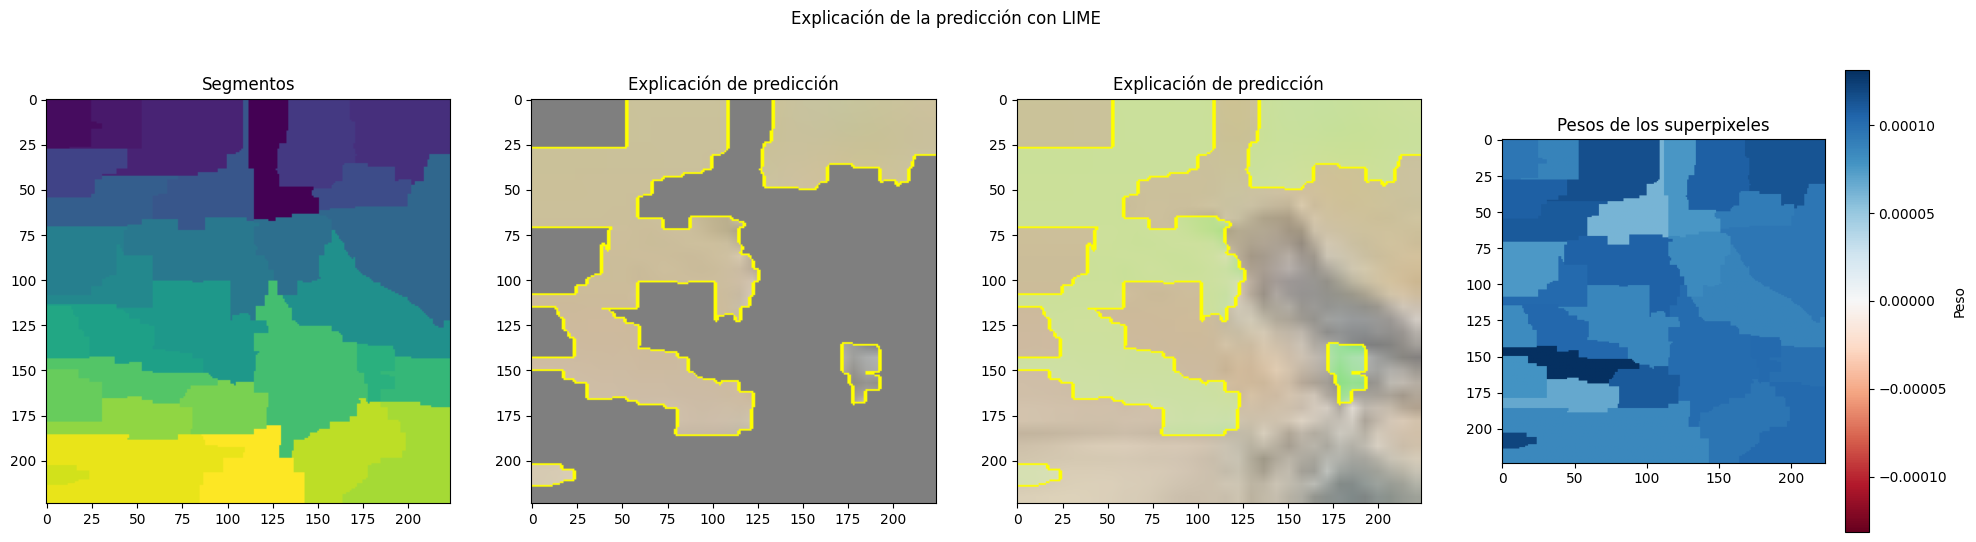

In [ ]:
image = images[9] # Cambiar imagen a analizar

# Realizar predicción
explanation = explainer.explain_instance(
    image,  
    model, 
    top_labels=2,
    hide_color=0,
    num_samples=1000,
)

temp, mask = explanation.get_image_and_mask(
    label=explanation.top_labels[0],
    positive_only=True,
    num_features=12,
    hide_rest=True,
)

# Prediccion real del modelo
pred = model.predict(np.expand_dims(image, axis=0))
print(f"Predicción real del modelo: {pred[0][0]}")
print(f"Predicción real del modelo: {['FAKE', 'REAL'][int(pred[0][0] >= 0.5)]}")


plt.figure(figsize=(24, 6))
plt.suptitle('Explicación de la predicción con LIME')
plt.subplot(1, 4, 1)
plt.imshow(explanation.segments)
plt.title("Segmentos")
plt.subplot(1, 4, 2)
plt.title("Explicación de predicción")
plt.imshow(mark_boundaries(temp / 2 + 0.5, mask))
plt.subplot(1, 4, 3)
temp, mask = explanation.get_image_and_mask(
    explanation.top_labels[0],
    positive_only=False,
    num_features=12,
    hide_rest=False,
)
plt.title("Explicación de predicción")
plt.imshow(mark_boundaries(temp / 2 + 0.5, mask))
plt.subplot(1, 4, 4)

# Seleccionar el índice de la clase más probable
top_class_index = explanation.top_labels[0]

# Extraer los pesos asociados a cada superpixel de la explicación
class_weights = explanation.local_exp[top_class_index]

# Crear un diccionario que mapea los superpixeles a sus pesos
superpixel_weights = dict(class_weights)

# Mapear los pesos a los superpixeles para generar un mapa de calor
heatmap = np.vectorize(superpixel_weights.get)(explanation.segments)

plt.imshow(heatmap, cmap='RdBu', vmin=-heatmap.max(), vmax=heatmap.max())
plt.colorbar(label='Peso')
plt.title('Pesos de los superpixeles')
plt.show()


## GradCAM

### Para VGG16

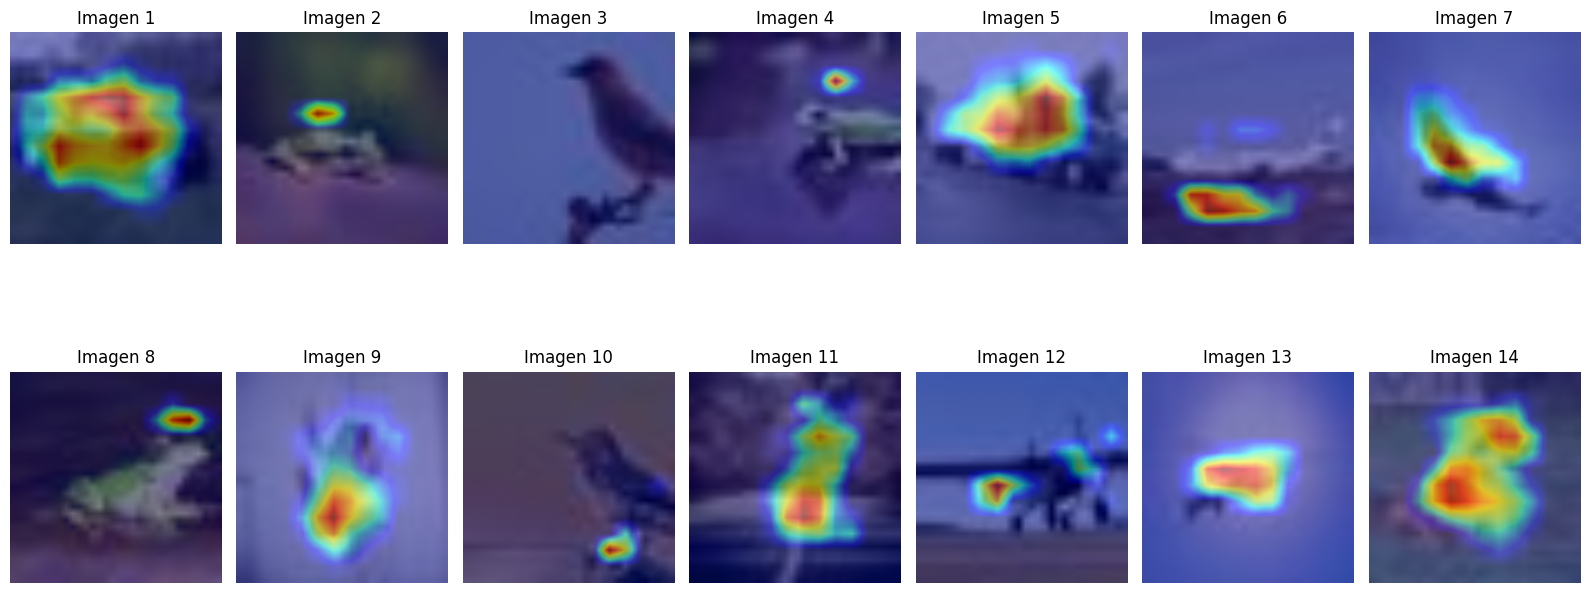

In [94]:
from tf_keras_vis.utils.model_modifiers import ReplaceToLinear
from tf_keras_vis.utils.scores import BinaryScore 
from tf_keras_vis.gradcam import Gradcam
from matplotlib import cm

replace2linear = ReplaceToLinear()
score = BinaryScore(target_values=1)

# Crear un lote con todas las imágenes
images = np.stack(images, axis=0)  

gradcam = Gradcam(
    model,
    model_modifier=replace2linear,
    clone=True
)

# Generar Grad-CAM para las imagenes

cam = gradcam(
    score,
    images,
    penultimate_layer=-1
)


fig, axes = plt.subplots(nrows=2, ncols=7, figsize=(16, 8))

# Reordenar axes para iterar sobre ellos fácilmente
axes = axes.flatten()

for i, current_img in enumerate(images):
        
    # Convertir el mapa de calor a un formato adecuado para la visualización
    heatmap = np.uint8(cm.jet(cam[i])[..., :3] * 255)

    ax = axes[i]  # Usar el array aplanado
    ax.set_title(f"Imagen {i+1}")
    ax.imshow(current_img)
    ax.imshow(heatmap, cmap='jet', alpha=0.5)
    ax.axis('off')
    

plt.tight_layout()
plt.show()
